## Proyecto de procesamiento de lenguaje natural
Estamos analizando: https://www.kaggle.com/competitions/feedback-prize-effectiveness/overview

### Preprocesamiento de datos

In [1]:
# imports y configuración de paths
from pathlib import Path
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk

BASE_DIR = Path(".")
DATA_DIR = BASE_DIR / "data"

PATH_TRAIN_CSV = DATA_DIR / "train.csv"
PATH_TEST_CSV = DATA_DIR / "test.csv"
PATH_SUB_CSV = DATA_DIR / "sample_submission.csv"

# Carpetas con ensayos en .txt
PATH_TRAIN_TXT = DATA_DIR / "train"
PATH_TEST_TXT  = DATA_DIR / "test"

print("Existe train.csv:", PATH_TRAIN_CSV.exists())
print("Existe test.csv:", PATH_TEST_CSV.exists())
print("Existe sample_submission.csv:", PATH_SUB_CSV.exists())
print("Dir train txt:", PATH_TRAIN_TXT, "| existe:", PATH_TRAIN_TXT.exists())
print("Dir test  txt:", PATH_TEST_TXT,  "| existe:", PATH_TEST_TXT.exists())


Existe train.csv: True
Existe test.csv: True
Existe sample_submission.csv: True
Dir train txt: data\train | existe: True
Dir test  txt: data\test | existe: True


In [2]:
# cargar CSVs
train_df = pd.read_csv(PATH_TRAIN_CSV)
test_df  = pd.read_csv(PATH_TEST_CSV)
sub_df   = pd.read_csv(PATH_SUB_CSV)

print("train_df shape:", train_df.shape)
print("test_df  shape:", test_df.shape)
print("sample_submission shape:", sub_df.shape)
print("\nColumnas train:", list(train_df.columns))
print("Columnas test :", list(test_df.columns))

# Mostrar 3 filas para confirmar estructura
display(train_df.head(3))

# Distribución de clases (si está disponible)
if "discourse_effectiveness" in train_df.columns:
    print("\nDistribución de etiquetas en train:")
    print(train_df["discourse_effectiveness"].value_counts(dropna=False))


train_df shape: (36765, 5)
test_df  shape: (10, 4)
sample_submission shape: (10, 4)

Columnas train: ['discourse_id', 'essay_id', 'discourse_text', 'discourse_type', 'discourse_effectiveness']
Columnas test : ['discourse_id', 'essay_id', 'discourse_text', 'discourse_type']


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate



Distribución de etiquetas en train:
discourse_effectiveness
Adequate       20977
Effective       9326
Ineffective     6462
Name: count, dtype: int64


train_df shape: (36765, 5) → Cada fila es un fragmento (discourse); hay 36,765 fragmentos.

test_df shape: (10, 4) → 10 fragmentos sin etiqueta (perfecto para pruebas locales).

### Cargar texto completo del ensayo (.txt) y unir por essay_id

In [3]:
# funciones para leer ensayos y unir
def read_essay_text(essay_id: str, split="train") -> str:
    """
    Lee el .txt de un ensayo dado su essay_id.
    split: 'train' o 'test' para elegir carpeta.
    """
    folder = PATH_TRAIN_TXT if split == "train" else PATH_TEST_TXT
    path = folder / f"{essay_id}.txt"
    if not path.exists():
        return ""
    try:
        return path.read_text(encoding="utf-8")
    except UnicodeDecodeError:
        # fallback por si hay caracteres raros
        return path.read_text(encoding="latin-1", errors="ignore")

# Construimos un df con ensayo_id único y el texto
essays_train = (
    train_df[["essay_id"]]
    .drop_duplicates()
    .assign(essay_text=lambda d: d["essay_id"].apply(lambda x: read_essay_text(x, split="train")))
)

print("Ensayos únicos en train:", essays_train.shape[0])
display(essays_train.head(3))

# Unimos el texto completo del ensayo a cada fila del train (nivel de discourse)
train_df = train_df.merge(essays_train, on="essay_id", how="left")
print("train_df + essay_text:", train_df.shape)


Ensayos únicos en train: 4191


,essay_id,essay_text
0,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h..."
9,00944C693682,Limiting the usage of cars has personal and pr...
20,00BD97EA4041,Should computers read the emotional expression...


train_df + essay_text: (36765, 6)


Hay varios fragmentos por ensayo.

### Limpieza ligera del texto

In [4]:
# limpieza ligera ===
PUNCT = string.punctuation.replace("'", "")  # conservamos comillas simples por si hay contracciones
PUNCT_RE = re.compile(f"[{re.escape(PUNCT)}]")

def normalize_whitespace(s: str) -> str:
    return re.sub(r"\s+", " ", s).strip()

def basic_clean(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.lower()
    # reemplazar puntuación rara (dejamos apostrofes)
    s = PUNCT_RE.sub(" ", s)
    # remover caracteres no-ascii problemáticos
    s = s.encode("ascii", errors="ignore").decode("ascii")
    # espacios
    s = normalize_whitespace(s)
    return s

# Aplicamos a discourse_text y essay_text
train_df["discourse_text_clean"] = train_df["discourse_text"].apply(basic_clean)
train_df["essay_text_clean"]     = train_df["essay_text"].apply(basic_clean)

display(train_df[["discourse_text", "discourse_text_clean"]].head(3))


,discourse_text,discourse_text_clean
0,"Hi, i'm Isaac, i'm going to be writing about h...",hi i'm isaac i'm going to be writing about how...
1,"On my perspective, I think that the face is a ...",on my perspective i think that the face is a n...
2,I think that the face is a natural landform be...,i think that the face is a natural landform be...


### Features simples para EDA
Contamos palabras, oraciones (regex sencilla), densidad de puntuación, mayúsculas, y conectores lógicos.

In [5]:
#  features simples
SENT_SPLIT_RE = re.compile(r"[.!?]+")
CONNECTORS = [
    "because","since","therefore","however","moreover","furthermore",
    "for example","for instance","in conclusion","on the other hand",
    "in addition","as a result","consequently","in contrast","thus"
]

def count_sentences(text: str) -> int:
    if not isinstance(text, str) or not text.strip():
        return 0
    parts = [p.strip() for p in SENT_SPLIT_RE.split(text) if p.strip()]
    return len(parts)

def word_count(text: str) -> int:
    if not isinstance(text, str) or not text.strip():
        return 0
    return len(text.split())

def punct_density(raw: str) -> float:
    if not isinstance(raw, str) or not raw:
        return 0.0
    puncts = sum(1 for ch in raw if ch in string.punctuation)
    return puncts / max(1, len(raw))

def uppercase_ratio(raw: str) -> float:
    if not isinstance(raw, str) or not raw:
        return 0.0
    ups = sum(1 for ch in raw if ch.isupper())
    letters = sum(1 for ch in raw if ch.isalpha())
    return ups / max(1, letters)

def count_connectors(clean_text: str) -> int:
    if not isinstance(clean_text, str):
        return 0
    t = f" {clean_text} "
    return sum(t.count(f" {w} ") for w in CONNECTORS)

# Features a nivel de fragmento (discourse)
train_df["disc_words"]      = train_df["discourse_text_clean"].apply(word_count)
train_df["disc_sents"]      = train_df["discourse_text"].apply(count_sentences)
train_df["disc_avg_wps"]    = (train_df["disc_words"] / train_df["disc_sents"].replace(0, np.nan)).fillna(train_df["disc_words"])
train_df["disc_punctdens"]  = train_df["discourse_text"].apply(punct_density)
train_df["disc_upcase"]     = train_df["discourse_text"].apply(uppercase_ratio)
train_df["disc_connectors"] = train_df["discourse_text_clean"].apply(count_connectors)

# Features a nivel de ensayo (repetidas por fila para facilitar groupby en EDA)
train_df["essay_words"]      = train_df["essay_text_clean"].apply(word_count)
train_df["essay_sents"]      = train_df["essay_text"].apply(count_sentences)
train_df["essay_avg_wps"]    = (train_df["essay_words"] / train_df["essay_sents"].replace(0, np.nan)).fillna(train_df["essay_words"])
train_df["essay_punctdens"]  = train_df["essay_text"].apply(punct_density)
train_df["essay_upcase"]     = train_df["essay_text"].apply(uppercase_ratio)
train_df["essay_connectors"] = train_df["essay_text_clean"].apply(count_connectors)

cols_show = ["discourse_type","discourse_effectiveness","disc_words","disc_sents","disc_avg_wps","disc_connectors"]
display(train_df[cols_show].head(5))


,discourse_type,discourse_effectiveness,disc_words,disc_sents,disc_avg_wps,disc_connectors
0,Lead,Adequate,67,3,22.333333,0
1,Position,Adequate,41,2,20.500000,1
2,Claim,Adequate,21,1,21.000000,1
3,Evidence,Adequate,72,4,18.000000,1
4,Counterclaim,Adequate,18,1,18.000000,1


### Codificar etiquetas (para modelado posterior)

In [6]:
# codificación de etiquetas
label_map = {"Ineffective":0, "Adequate":1, "Effective":2}
if "discourse_effectiveness" in train_df.columns:
    train_df["label"] = train_df["discourse_effectiveness"].map(label_map)
    print(train_df[["discourse_effectiveness","label"]].drop_duplicates().sort_values("label"))


  discourse_effectiveness  label
5             Ineffective      0
0                Adequate      1
9               Effective      2


In [7]:
print(train_df["discourse_type"].value_counts())


discourse_type
Evidence                12105
Claim                   11977
Position                 4024
Concluding Statement     3351
Lead                     2291
Counterclaim             1773
Rebuttal                 1244
Name: count, dtype: int64


## EDA

### Información del dataset

In [8]:
print("Filas:", len(train_df))
print("Columnas:", list(train_df.columns))
print("Etiquetas:", train_df["discourse_effectiveness"].value_counts())
print("Tipos de discurso:", train_df["discourse_type"].value_counts())


Filas: 36765
Columnas: ['discourse_id', 'essay_id', 'discourse_text', 'discourse_type', 'discourse_effectiveness', 'essay_text', 'discourse_text_clean', 'essay_text_clean', 'disc_words', 'disc_sents', 'disc_avg_wps', 'disc_punctdens', 'disc_upcase', 'disc_connectors', 'essay_words', 'essay_sents', 'essay_avg_wps', 'essay_punctdens', 'essay_upcase', 'essay_connectors', 'label']
Etiquetas: discourse_effectiveness
Adequate       20977
Effective       9326
Ineffective     6462
Name: count, dtype: int64
Tipos de discurso: discourse_type
Evidence                12105
Claim                   11977
Position                 4024
Concluding Statement     3351
Lead                     2291
Counterclaim             1773
Rebuttal                 1244
Name: count, dtype: int64


### Distribución de clases y tipos de discurso

In [9]:

ct = pd.crosstab(train_df["discourse_type"], train_df["discourse_effectiveness"], normalize="index").round(3)
display(ct)  # proporción por tipo


discourse_effectiveness,Adequate,Effective,Ineffective
discourse_type,,,
Claim,0.593,0.284,0.123
Concluding Statement,0.580,0.246,0.173
Counterclaim,0.649,0.236,0.116
Evidence,0.501,0.238,0.261
Lead,0.543,0.298,0.159
Position,0.692,0.191,0.117
Rebuttal,0.557,0.273,0.170


### Distribución de caracteristicas por clase

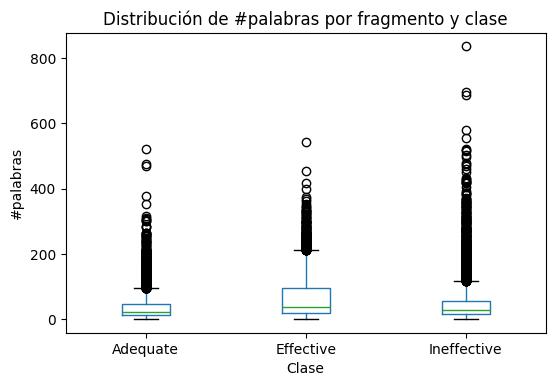

In [10]:
import matplotlib.pyplot as plt
train_df.boxplot(column="disc_words", by="discourse_effectiveness", grid=False, figsize=(6,4))
plt.suptitle("")
plt.title("Distribución de #palabras por fragmento y clase")
plt.xlabel("Clase")
plt.ylabel("#palabras")
plt.show()

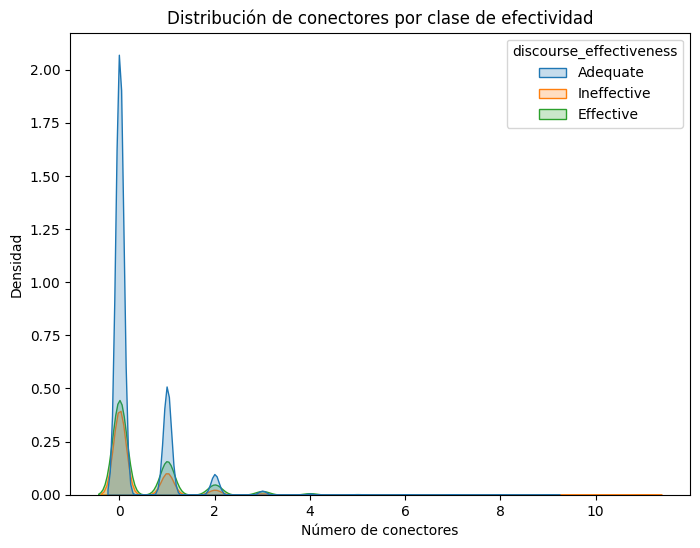

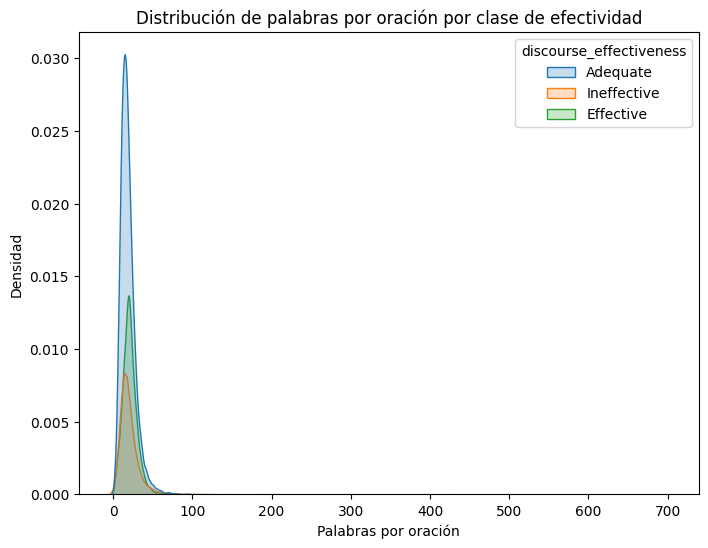

In [11]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=train_df, x="disc_connectors", hue="discourse_effectiveness", fill=True)
plt.title("Distribución de conectores por clase de efectividad")
plt.xlabel("Número de conectores")
plt.ylabel("Densidad")
plt.show()

plt.figure(figsize=(8, 6))
sns.kdeplot(data=train_df, x="disc_avg_wps", hue="discourse_effectiveness", fill=True)
plt.title("Distribución de palabras por oración por clase de efectividad")
plt.xlabel("Palabras por oración")
plt.ylabel("Densidad")
plt.show()

### Estadísticas por clase

discourse_effectiveness
Ineffective    0.353451
Adequate       0.293941
Effective      0.531096
Name: disc_connectors, dtype: float64


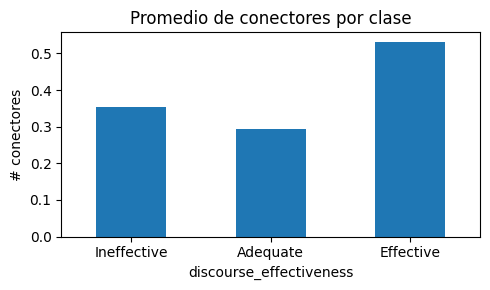

In [12]:
means = train_df.groupby("discourse_effectiveness")["disc_connectors"].mean().reindex(["Ineffective","Adequate","Effective"])
print(means)
means.plot(kind="bar", figsize=(5,3), rot=0, title="Promedio de conectores por clase")
plt.ylabel("# conectores")
plt.tight_layout()
plt.show()


### Correlaciones

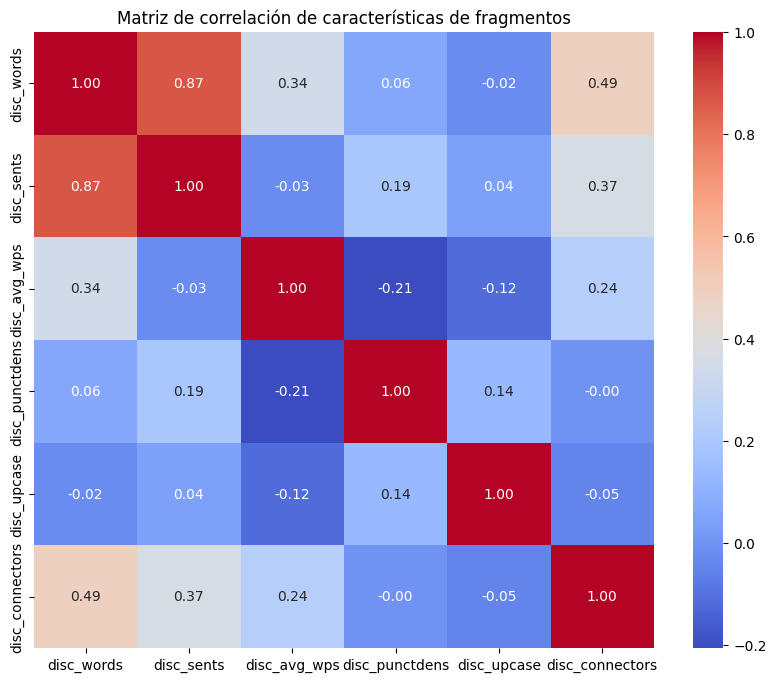

In [13]:
numeric_features = ["disc_words", "disc_sents", "disc_avg_wps", "disc_punctdens", "disc_upcase", "disc_connectors"]

correlation_matrix = train_df[numeric_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación de características de fragmentos")
plt.show()

### Limpieza de Datos

##### Validación de esquema y etiquetas

In [14]:
required_train = {"essay_id","discourse_id","discourse_text","discourse_type","discourse_effectiveness"}
required_test  = {"essay_id","discourse_id","discourse_text","discourse_type"}

miss_train = required_train - set(train_df.columns)
miss_test  = required_test  - set(test_df.columns)
assert not miss_train, f"Faltan columnas en train: {miss_train}"
assert not miss_test,  f"Faltan columnas en test : {miss_test}"

valid_labels = {"Ineffective","Adequate","Effective"}
bad = set(train_df["discourse_effectiveness"].unique()) - valid_labels
assert not bad, f"Etiquetas no válidas: {bad}"

print("✓ Esquema y etiquetas validados")


✓ Esquema y etiquetas validados


##### Unir texto completo del ensayo y auditar faltantes .txt

In [18]:
from pathlib import Path

PATH_TRAIN_TXT = DATA_DIR / "train"
PATH_TEST_TXT  = DATA_DIR / "test"

def read_essay_text(essay_id: str, split="train") -> str:
    folder = PATH_TRAIN_TXT if split == "train" else PATH_TEST_TXT
    path = folder / f"{essay_id}.txt"
    if not path.exists():
        return ""
    try:
        return path.read_text(encoding="utf-8")
    except UnicodeDecodeError:
        return path.read_text(encoding="latin-1", errors="ignore")

essays_train = (
    train_df[["essay_id"]].drop_duplicates()
    .assign(essay_text=lambda d: d["essay_id"].apply(lambda x: read_essay_text(x, "train")))
)

missing_txt = (essays_train["essay_text"].str.len() == 0).sum()
print(f"Ensayos únicos en train: {len(essays_train)} | sin .txt: {missing_txt}")

train_df = train_df.merge(essays_train, on="essay_id", how="left")
print("train_df tras merge essay_text:", train_df.shape)


Ensayos únicos en train: 4191 | sin .txt: 0
train_df tras merge essay_text: (36765, 23)


##### Limpieza ligera del texto

In [19]:
import re, string

PUNCT_KEEP_APOS = string.punctuation.replace("'", "")
PUNCT_RE = re.compile(f"[{re.escape(PUNCT_KEEP_APOS)}]")

def normalize_whitespace(s: str) -> str:
    return re.sub(r"\s+", " ", s).strip()

def basic_clean(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = PUNCT_RE.sub(" ", s)                       # reducir puntuación
    s = s.encode("ascii", "ignore").decode("ascii") # quitar no-ascii problemático
    return normalize_whitespace(s)

train_df["discourse_text_clean"] = train_df["discourse_text"].astype(str).apply(basic_clean)
train_df["essay_text_clean"]     = train_df["essay_text"].astype(str).apply(basic_clean)

train_df[["discourse_text","discourse_text_clean"]].head(3)


,discourse_text,discourse_text_clean
0,"Hi, i'm Isaac, i'm going to be writing about h...",hi i'm isaac i'm going to be writing about how...
1,"On my perspective, I think that the face is a ...",on my perspective i think that the face is a n...
2,I think that the face is a natural landform be...,i think that the face is a natural landform be...


##### Eliminar duplicados y filas vacías

In [20]:
before = len(train_df)

train_df = train_df.drop_duplicates(
    subset=["essay_id","discourse_id","discourse_text","discourse_type","discourse_effectiveness"]
)

train_df = train_df[train_df["discourse_text"].astype(str).str.strip().ne("")]

after = len(train_df)
print(f"Filas antes: {before} | después: {after} | removidas: {before-after}")

print("Nulos clave:\n",
      train_df[["essay_id","discourse_text","discourse_type","discourse_effectiveness"]].isna().sum())


Filas antes: 36765 | después: 36765 | removidas: 0
Nulos clave:
 essay_id                   0
discourse_text             0
discourse_type             0
discourse_effectiveness    0
dtype: int64


##### Codificar etiquetas y auditar distribución de clases

In [21]:
label_map = {"Ineffective":0, "Adequate":1, "Effective":2}
train_df["label"] = train_df["discourse_effectiveness"].map(label_map).astype(int)

cls_counts = train_df["discourse_effectiveness"].value_counts().reindex(["Ineffective","Adequate","Effective"])
print("Distribución de clases:\n", cls_counts)

N = cls_counts.sum()
class_weights = {i: (N / (len(cls_counts) * c)) for i, c in enumerate(cls_counts.values)}
print("Pesos de clase sugeridos:", class_weights)

Distribución de clases:
 discourse_effectiveness
Ineffective     6462
Adequate       20977
Effective       9326
Name: count, dtype: int64
Pesos de clase sugeridos: {0: np.float64(1.8964716805942432), 1: np.float64(0.5842112790198789), 2: np.float64(1.31406819644006)}


##### Guardar datasets limpios

In [25]:
OUT_DIR = DATA_DIR

cols_keep_train = [
    "essay_id","discourse_id","discourse_type",
    "discourse_text","discourse_text_clean",
    "essay_text","essay_text_clean",
    "discourse_effectiveness","label"
]
cols_keep_test = ["essay_id","discourse_id","discourse_type","discourse_text"]

train_df[cols_keep_train].to_csv(OUT_DIR/"clean_train.csv", index=False)
test_df[cols_keep_test].to_csv(OUT_DIR/"clean_test.csv", index=False)

print("Guardados:", OUT_DIR/"clean_train.csv", "|", OUT_DIR/"clean_test.csv")

Guardados: data\clean_train.csv | data\clean_test.csv


##### Split por essay_id

In [26]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
groups = train_df["essay_id"].values
train_idx, val_idx = next(gss.split(train_df, train_df["label"], groups))

train_split = train_df.iloc[train_idx].reset_index(drop=True)
val_split   = train_df.iloc[val_idx].reset_index(drop=True)

train_split.to_csv(OUT_DIR/"clean_train_split.csv", index=False)
val_split.to_csv(OUT_DIR/"clean_val_split.csv", index=False)

print("Ensayos únicos -> train:", train_split["essay_id"].nunique(),
      "| val:", val_split["essay_id"].nunique())
print("Tamaños -> train:", len(train_split), "| val:", len(val_split))

Ensayos únicos -> train: 3352 | val: 839
Tamaños -> train: 29410 | val: 7355


##### Baseline: TF-IDF + Regresión Logística

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

X_train = train_split["discourse_text_clean"].astype(str)
y_train = train_split["label"].values
X_val   = val_split["discourse_text_clean"].astype(str)
y_val   = val_split["label"].values

tfidf = TfidfVectorizer(min_df=3, ngram_range=(1,2), max_features=100_000)
Xtr = tfidf.fit_transform(X_train)
Xva = tfidf.transform(X_val)

# Pesos de clase (recalculados en el split):
class_counts = np.bincount(y_train, minlength=3)
N = class_counts.sum()
weights = {i: N/(len(class_counts)*c) for i,c in enumerate(class_counts)}

clf = LogisticRegression(max_iter=200, class_weight=weights)
clf.fit(Xtr, y_train)
pred = clf.predict(Xva)

print(classification_report(
    y_val, pred,
    target_names=["Ineffective","Adequate","Effective"],
    digits=4
))
print("Matriz de confusión:\n", confusion_matrix(y_val, pred))


##### Matriz de confusión

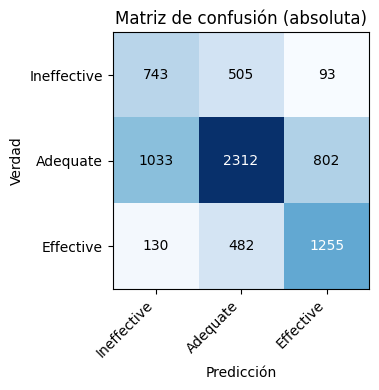

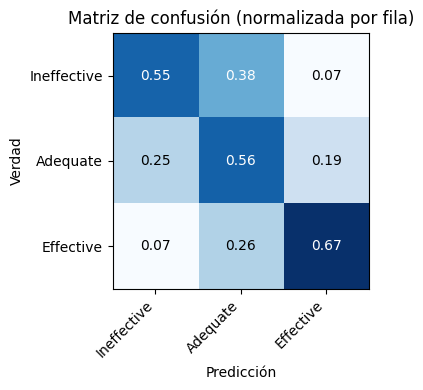

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

labels_names = ["Ineffective","Adequate","Effective"]

cm = confusion_matrix(y_val, pred, labels=[0,1,2])
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

def plot_cm(cm_matrix, title, normalized=False):
    plt.figure(figsize=(5,4))
    plt.imshow(cm_matrix, interpolation="nearest", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicción")
    plt.ylabel("Verdad")
    plt.xticks(np.arange(len(labels_names)), labels_names, rotation=45, ha="right")
    plt.yticks(np.arange(len(labels_names)), labels_names)

    # anotar valores dentro de las celdas
    for i in range(cm_matrix.shape[0]):
        for j in range(cm_matrix.shape[1]):
            val = f"{cm_matrix[i, j]:.2f}" if normalized else f"{int(cm_matrix[i, j])}"
            plt.text(j, i, val,
                     ha="center", va="center",
                     color="white" if cm_matrix[i, j] > cm_matrix.max()/2 else "black")

    plt.tight_layout()
    plt.show()

# Mostrar ambas
plot_cm(cm, "Matriz de confusión (absoluta)", normalized=False)
plot_cm(cm_norm, "Matriz de confusión (normalizada por fila)", normalized=True)
